In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor

# Excel file betöltése

excel_data = pd.read_excel("Play_by_play.xlsx")

# Első pár sor kiírása
excel_data.head()


,Időbélyeg,Field pozíció,Down,Yards to gain,Felállás,Motion,Play,Gain / Loss,Result,Penalty yards,Result Extra,Play iránya,Felállás iránya,Unnamed: 13
0,2023-05-07 17:59:10,s38,1,10,BORZ,NaN,WHAM,3,Rush,NaN,NaN,jobb,jobb,NaN
1,2023-05-07 17:59:53,s41,2,7,LONGHORN,NaN,COUNTER,8,Rush,NaN,NaN,jobb,jobb,NaN
2,2023-05-07 18:03:51,s49,1,10,GATOR,NaN,ALL HITCH,5,Complete,NaN,NaN,bal,bal,1.0
3,2023-05-07 18:04:46,e46,2,5,SPREAD,NaN,PATRIOTS,35,Complete,NaN,NaN,bal,bal,NaN
4,2023-05-07 18:05:45,e11,1,10,LONGHORN,NaN,COUNTER,6,Rush,NaN,NaN,jobb,jobb,NaN


# Adatok megjelenítése, majd tisztiása

In [2]:
# Adattisztítás
# Eltávolítjuk a teljesen üres sorokat, ha vannak
tisztitott_adat = excel_data.dropna(how='all')

# Tisztítjuk a 'Field pozíció' oszlopot, ami tartalmazhat hibás adatokat
# Azt várjuk, hogy ezek az értékek két karakterből állnak: egy betű (s vagy e) és egy szám
tisztitott_adat = tisztitott_adat[tisztitott_adat['Field pozíció'].str.match(r'[se][0-9]+') == True]

# Konvertáljuk az 'Időbélyeg' oszlopot pandas datetime objektummá, ha még nem az
tisztitott_adat['Időbélyeg'] = pd.to_datetime(tisztitott_adat['Időbélyeg'], errors='coerce')

# Eltávolítjuk a sorokat, ahol az 'Időbélyeg' értéke NaN
tisztitott_adat = tisztitott_adat.dropna(subset=['Időbélyeg'])

# Feltöltöm a 'Result Extra hiányzo sorait a 'Nincs különleges esemény értékkel'
tisztitott_adat['Result Extra'] = excel_data['Result Extra'].fillna('Nincs különleges esemény')


# Megvizsgáljuk az adatokat újra, hogy lássuk a tisztítás hatását
tisztitott_adat.head(), tisztitott_adat.info()



<class 'pandas.core.frame.DataFrame'>
Index: 330 entries, 0 to 333
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   Időbélyeg        330 non-null    datetime64[ns]
 1   Field pozíció    330 non-null    object        
 2   Down             330 non-null    int64         
 3   Yards to gain    330 non-null    int64         
 4   Felállás         330 non-null    object        
 5   Motion           26 non-null     object        
 6   Play             330 non-null    object        
 7   Gain / Loss      330 non-null    int64         
 8   Result           330 non-null    object        
 9   Penalty yards    25 non-null     float64       
 10  Result Extra     330 non-null    object        
 11  Play iránya      330 non-null    object        
 12  Felállás iránya  330 non-null    object        
 13  Unnamed: 13      1 non-null      float64       
dtypes: datetime64[ns](1), float64(2), int64(3), obj

(            Időbélyeg Field pozíció  Down  Yards to gain  Felállás Motion  \
 0 2023-05-07 17:59:10           s38     1             10      BORZ    NaN   
 1 2023-05-07 17:59:53           s41     2              7  LONGHORN    NaN   
 2 2023-05-07 18:03:51           s49     1             10     GATOR    NaN   
 3 2023-05-07 18:04:46           e46     2              5    SPREAD    NaN   
 4 2023-05-07 18:05:45           e11     1             10  LONGHORN    NaN   
 
         Play  Gain / Loss    Result  Penalty yards              Result Extra  \
 0       WHAM            3      Rush            NaN  Nincs különleges esemény   
 1    COUNTER            8      Rush            NaN  Nincs különleges esemény   
 2  ALL HITCH            5  Complete            NaN  Nincs különleges esemény   
 3   PATRIOTS           35  Complete            NaN  Nincs különleges esemény   
 4    COUNTER            6      Rush            NaN  Nincs különleges esemény   
 
   Play iránya Felállás iránya  Unnamed: 1

In [3]:
# Megvizsgáljuk az adatokat újra, hogy lássuk a tisztítás hatását
tisztitott_adat.head()


,Időbélyeg,Field pozíció,Down,Yards to gain,Felállás,Motion,Play,Gain / Loss,Result,Penalty yards,Result Extra,Play iránya,Felállás iránya,Unnamed: 13
0,2023-05-07 17:59:10,s38,1,10,BORZ,NaN,WHAM,3,Rush,NaN,Nincs különleges esemény,jobb,jobb,NaN
1,2023-05-07 17:59:53,s41,2,7,LONGHORN,NaN,COUNTER,8,Rush,NaN,Nincs különleges esemény,jobb,jobb,NaN
2,2023-05-07 18:03:51,s49,1,10,GATOR,NaN,ALL HITCH,5,Complete,NaN,Nincs különleges esemény,bal,bal,1.0
3,2023-05-07 18:04:46,e46,2,5,SPREAD,NaN,PATRIOTS,35,Complete,NaN,Nincs különleges esemény,bal,bal,NaN
4,2023-05-07 18:05:45,e11,1,10,LONGHORN,NaN,COUNTER,6,Rush,NaN,Nincs különleges esemény,jobb,jobb,NaN


In [4]:
# Tisztitott oszlop adatainak kiírása
tisztitott_adat['Result Extra'].value_counts()


Result Extra
Nincs különleges esemény    308
Touch Down                   18
Fumble                        4
Name: count, dtype: int64

# Vizualizációk

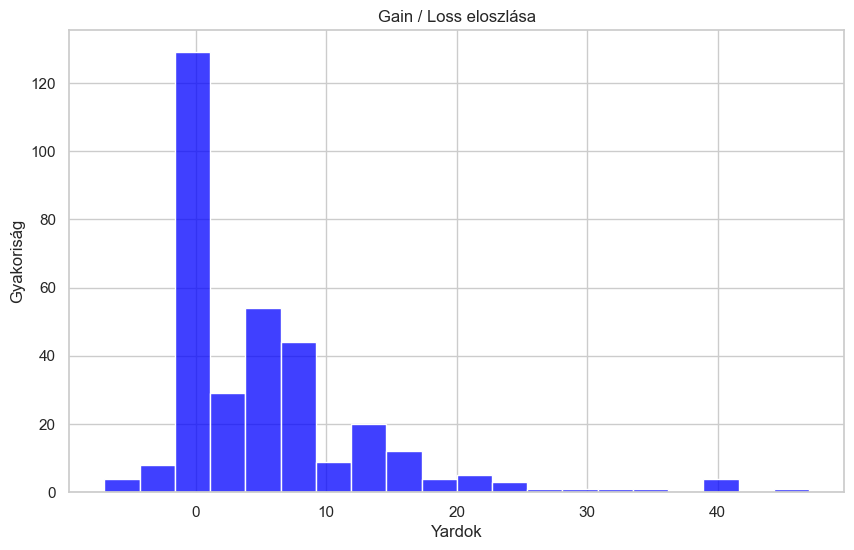

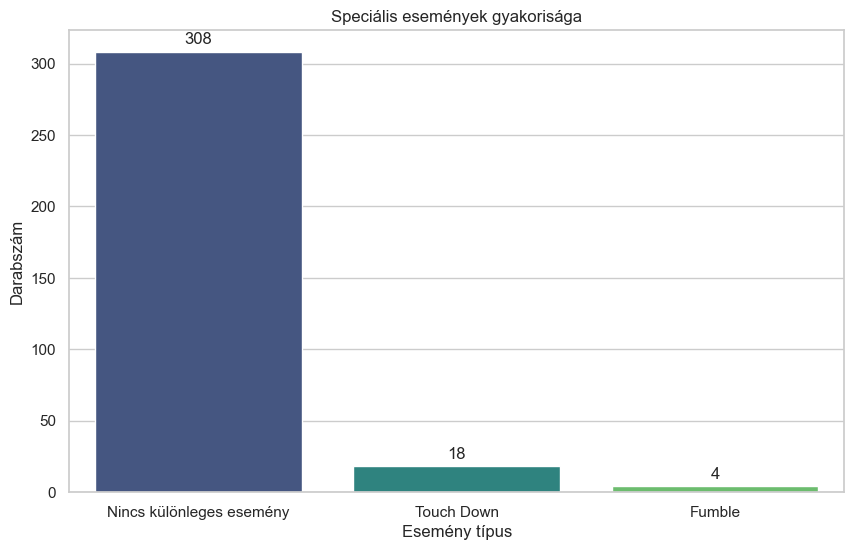

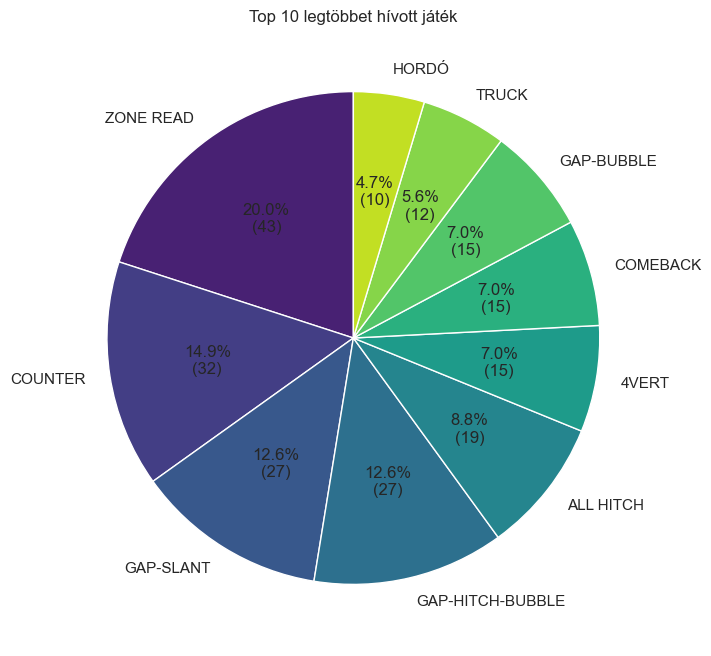

<Figure size 1000x600 with 0 Axes>

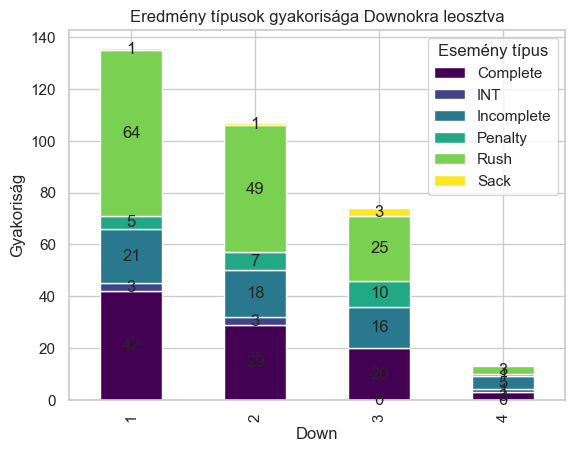

<Figure size 1000x600 with 0 Axes>

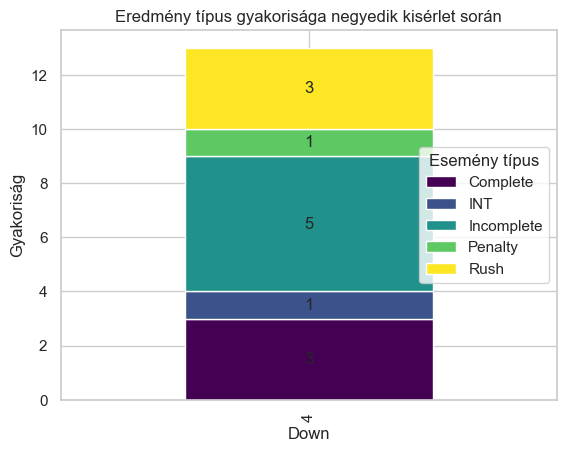

In [5]:
# Az ábrák esztétikai stílusának beállítása
sns.set(style="whitegrid")

# Függvény a kördiagram automatikus százalékértékének formázásához
def autopct_format(values):
    def my_format(pct):
        total = sum(values)
        val = int(round(pct*total/100.0))
        return '{p:.1f}%\n({v:d})'.format(p=pct, v=val)
    return my_format

# 1. Gain / Loss eloszlása: Histogram az elnyert vagy elveszített yardok eloszlásáról.
plt.figure(figsize=(10, 6))
sns.histplot(data=tisztitott_adat, x='Gain / Loss', bins=20, color='blue')
plt.title('Gain / Loss eloszlása')
plt.xlabel('Yardok')
plt.ylabel('Gyakoriság')
plt.show()

# 2. Oszlopdiagram, mely az "Result Extra" eseményeket ábrázolja, darabszámokkal.
plt.figure(figsize=(10, 6))
result_extra_counts = tisztitott_adat['Result Extra'].value_counts()
bar_plot = sns.barplot(x=result_extra_counts.index, y=result_extra_counts.values, palette='viridis')
plt.title('Speciális események gyakorisága')
plt.xlabel('Esemény típus')
plt.ylabel('Darabszám')

for p in bar_plot.patches:
    bar_plot.annotate(format(p.get_height(), '.0f'), 
                      (p.get_x() + p.get_width() / 2., p.get_height()), 
                      ha = 'center', va = 'center', 
                      xytext = (0, 9), 
                      textcoords = 'offset points')
plt.show()

# 3.Top 10 legtöbbet játszott játék: Kördiagram a leggyakrabban játszott játékok százalékos megoszlásáról.
plt.figure(figsize=(10, 8))
top_plays = tisztitott_adat['Play'].value_counts().head(10)
plt.pie(top_plays, labels=top_plays.index, autopct=autopct_format(top_plays.values), startangle=90, colors=sns.color_palette('viridis', n_colors=10))
plt.title('Top 10 legtöbbet hívott játék')
plt.show()

# 4. Result típusok gyakorisága Down szerint:
#Többváltozós oszlopdiagram, amely a különböző "Down"-ok szerinti "Result" típusok gyakoriságát mutatja.
plt.figure(figsize=(10, 6))
result_down_pivot = tisztitott_adat.pivot_table(index='Down', columns='Result', values='Gain / Loss', aggfunc='count').fillna(0)
stacked = result_down_pivot.plot(kind='bar', stacked=True, colormap='viridis')
plt.title('Eredmény típusok gyakorisága Downokra leosztva')
plt.xlabel('Down')
plt.ylabel('Gyakoriság')
plt.legend(title='Esemény típus')

for bars in stacked.containers:
    stacked.bar_label(bars, label_type='center')
plt.show()

# Külön vizualizálás a '4. down' esetére
data_for_down_4 = tisztitott_adat[tisztitott_adat['Down'] == 4]
result_down_4_pivot = data_for_down_4.pivot_table(index='Down', columns='Result', values='Gain / Loss', aggfunc='count').fillna(0)
plt.figure(figsize=(10, 6))
stacked_down_4 = result_down_4_pivot.plot(kind='bar', stacked=True, colormap='viridis')
plt.title('Eredmény típus gyakorisága negyedik kisérlet során')
plt.xlabel('Down')
plt.ylabel('Gyakoriság')
plt.legend(title='Esemény típus')
for bars in stacked_down_4.containers:
    stacked_down_4.bar_label(bars, label_type='center')
plt.show()



# Statisztikák

In [6]:

# Időbélyeg eldobása
data = tisztitott_adat.drop(columns=['Időbélyeg'])

# 1. Alapvető leíró statisztikák - 
#A megszerzett vagy elvesztett yardok eloszlásának, a különféle eredmények gyakoriságának
#és más számításoknak a megismerése.
descriptive_stats_numerical = data.describe()

descriptive_stats_categorical = data.describe(include=['object'])

# Létrehoz egy új oszlopot, amely az értékeket 'Pozitív' és 'Negatív' kategóriákba sorolja
data['Penalty'] = data['Penalty yards'].apply(lambda x: 'Positive' if x > 0 else ('Negative' if x < 0 else 'Zero'))

# Összegezzük a 'Penalty yards' oszlop értékeit a 'Penalty Type' szerint csoportosítva.
penalty_statistics = data.groupby('Penalty')['Penalty yards'].sum()

# Kitöröljük a nula értékeket
penalty_statistics = penalty_statistics[penalty_statistics.index != 'Zero']

# Átnevezés
penalty_statistics_renamed = penalty_statistics.rename(index={
    'Negative': 'Kapott yardok',
    'Positive': 'Szerzett yardok'
})
# Kiírás
print(penalty_statistics_renamed)

# Létrehoz egy új oszlopot, amely az értékeket 'Pozitív' és 'Negatív' kategóriákba sorolja
data['Gain/Loss Type'] = data['Gain / Loss'].apply(lambda x: 'Positive' if x > 0 else ('Negative' if x < 0 else 'Zero'))

# 'Gain / Loss' oszlop értékeit a 'Gain/Loss Type' szerint csoportosítom.
gain_loss_statistics = data.groupby('Gain/Loss Type')['Gain / Loss'].sum()

# Nulla érték törlése
gain_loss_statistics = gain_loss_statistics[gain_loss_statistics.index != 'Zero']

# Átnevezés
gain_loss_statistics_renamed = gain_loss_statistics.rename(index={
    'Negative': 'Negatív értékek összege',
    'Positive': 'Pozitív értékek összege'
})

# Kiírás
print(gain_loss_statistics_renamed)

zero_count = (data['Gain / Loss'] == 0).sum()
print("Nulla érték előfordulása: ", zero_count)


# 2. Korrelációs elemzés
#Annak vizsgálata, hogy van-e összefüggés a kísérletek száma (downs),
#a megszerezni kívánt yardok (yards to gain)
#és a ténylegesen megszerzett vagy elvesztett yardok között.
correlation_matrix = data[['Down', 'Yards to gain', 'Gain / Loss']].corr()

# 3.Csoportosított statisztikák 
#A játéktípusok és eredménytípusok szerinti átlagos,
#maximális és minimális yardok megszerzésének vagy elvesztésének elemzése.
grouped_by_play = data.groupby('Play')['Gain / Loss'].agg(['mean', 'max', 'min', 'count'])
grouped_by_result = data.groupby('Result')['Gain / Loss'].agg(['mean', 'max', 'min', 'count'])
# 'Complete', 'Incomplete', 'INT' sorok 'count' értékeinek összeadása
passzok_szama = grouped_by_result.loc[['Complete', 'Incomplete', 'INT'], 'count'].sum()

# 4. Gyakoriság elemzés
#Az egyes játékok milyen gyakran eredményeznek különleges kimeneteleket, mint touchdownok vagy sikeres passzok
frequency_of_special_results = data['Result Extra'].value_counts()

# Display the results
print("Leíró statisztikák numerikus adatokhoz:\n", descriptive_stats_numerical)
print("\nLeíró statisztikák kategórikus adatokhoz:\n", descriptive_stats_categorical)
print("\nKorrelácios mátrix:\n", correlation_matrix)
print("\nCsoportosított statisztika playenként:\n", grouped_by_play)
print("\nCsoportosított statisztika eredmények alapján:\n", grouped_by_result)
print("\nPasszok száma:", passzok_szama)
print("\nKülönleges események gyakorisága:\n", frequency_of_special_results)


Penalty
Kapott yardok     -130.0
Szerzett yardok     85.0
Name: Penalty yards, dtype: float64
Gain/Loss Type
Negatív értékek összege     -51
Pozitív értékek összege    1833
Name: Gain / Loss, dtype: int64
Nulla érték előfordulása:  107
Leíró statisztikák numerikus adatokhoz:
              Down  Yards to gain  Gain / Loss  Penalty yards  Unnamed: 13
count  330.000000     330.000000   330.000000      25.000000          1.0
mean     1.890909       8.203030     5.400000      -1.800000          1.0
std      0.885672       3.982254     7.886197       9.561206          NaN
min      1.000000       1.000000    -7.000000     -15.000000          1.0
25%      1.000000       5.000000     0.000000     -10.000000          1.0
50%      2.000000      10.000000     3.000000      -5.000000          1.0
75%      3.000000      10.000000     8.000000       5.000000          1.0
max      4.000000      30.000000    47.000000      15.000000          1.0

Leíró statisztikák kategórikus adatokhoz:
        Field 

# Elemzés AI segítségével

Ai tanítás

In [7]:
data = tisztitott_adat.dropna(subset=['Gain / Loss', 'Field pozíció', 'Down', 'Yards to gain', 'Play'])


# Jellemzők és célváltozó kiválasztása
features = data[['Field pozíció', 'Down', 'Yards to gain', 'Play']]
target = data['Gain / Loss']

# Kategórikus jellemzők előfeldolgozása
categorical_features = ['Field pozíció', 'Play']
categorical_transformer = OneHotEncoder(handle_unknown='ignore')

# Oszloptranszformátor az előfeldolgozáshoz
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', categorical_transformer, categorical_features)
    ], remainder='passthrough')

# Adatcső (pipeline) létrehozása a Random Forest regresszorral
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(n_estimators=100, random_state=0))
])

# Adatok felosztása tanító és teszt halmazra
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=0)

# Modell tanítása
model.fit(X_train, y_train)

# Modell értékelése
predictions = model.predict(X_test)
mse = mean_squared_error(y_test, predictions)
print("Átlagos négyzetes hiba:", mse)
rms = np.sqrt(mse)  # Számolja ki a gyök átlagos négyzetes hibát (RMS)
print("Gyök átlagos négyzetes hiba (RMS):", rms)


Átlagos négyzetes hiba: 40.90900857491583
Gyök átlagos négyzetes hiba (RMS): 6.3960150543065355


In [ ]:
def predict_gain_loss_interactively():
    # Input bekérés
    print("Kérlek add meg a szükséges értékeket a Gain/Loss előrejelzéséhez:")
    field_position = input("Field Pozició (pl: 's38'): ")
    down = int(input("Down (pl: 1, 2, 3, 4): "))
    yards_to_gain = int(input("Megtenni kívánt yard (pl: 10): "))
    play = input("Játék típus (pl: 'WHAM'): ")
    

    input_data = pd.DataFrame({
        'Field pozíció': [field_position],
        'Down': [down],
        'Yards to gain': [yards_to_gain],
        'Play': [play]
    })


    predicted_gain_loss = model.predict(input_data)
    return predicted_gain_loss[0]


predicted_result = predict_gain_loss_interactively()
print(f"Előrejelzett Gain/Loss: {predicted_result:.2f} yards")


Kérlek add meg a szükséges értékeket a Gain/Loss előrejelzéséhez:


In [ ]:
# Adatok előkészítése, eltávolítva az extrém értékeket z-score segítségével
z_scores = stats.zscore(data['Gain / Loss'])
abs_z_scores = abs(z_scores)
filtered_entries = (abs_z_scores < 3) 
data = data[filtered_entries]

# Távolítsuk el a ritkán előforduló játéktípusokat
play_counts = data['Play'].value_counts()
data = data[data['Play'].isin(play_counts[play_counts > 1].index)]

# Adatok előkészítése
X = data[['Field pozíció', 'Down', 'Yards to gain', 'Play']] 
y = data['Gain / Loss']

# Kategórikus adatok előfeldolgozása
categorical_features = ['Field pozíció', 'Play']
preprocessor = ColumnTransformer(
    transformers=[
        ('encoder', OneHotEncoder(handle_unknown='ignore'), categorical_features),
    ], remainder='passthrough'
)

# Regressziós modell előkészítése
regression_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(random_state=0))
])

# Adatok szétválasztása tanító és teszt adatokra
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# Regressziós modell tanítása
regression_pipeline.fit(X_train, y_train)

# Modell predikciói és értékelése
predictions = regression_pipeline.predict(X_test)
mse = mean_squared_error(y_test, predictions)
print("Átlagos négyzetes hiba:", mse)
rms = np.sqrt(mse)  # Számolja ki a gyök átlagos négyzetes hibát (RMS)
print("Gyök átlagos négyzetes hiba (RMS):", rms)


In [ ]:
def recommend_best_play():
    print("Kérlek add meg a szükséges értékeket a legjobb Játék ajánlásához:")
    field_position = input("Field Pozició (pl: 's38'): ")
    down = int(input("Down (pl: 1, 2, 3, 4): "))
    yards_to_gain = int(input("Yards to Gain (pl: 10): "))
    desired_advance = int(input("Megtenni kívánt yard (pl: 5): "))

    # Játékok kiszűrése az adathalmazból
    unique_plays = data['Play'].unique()

    # Gain/Loss előrejelzése
    best_play = None
    min_difference = float('inf')
    
    for play in unique_plays:
        input_features = pd.DataFrame({
            'Field pozíció': [field_position],
            'Down': [down],
            'Yards to gain': [yards_to_gain],
            'Play': [play]
        })
        predicted_gain = regression_pipeline.predict(input_features)[0]
        difference = abs(predicted_gain - desired_advance)

        if difference < min_difference:
            min_difference = difference
            best_play = play

    print(f"Feltételezhető legjobb játék: {best_play} (Várható gain/loss: {predicted_gain:.2f} yard, Cél: {desired_advance} yard)")

recommend_best_play()
